In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [39]:
try:
    df = pd.read_csv('/content/winequality-red.csv')
except FileNotFoundError:
    print("Error: winequality-red.csv not found!")

maxdepth= 8

train_data , test_data = train_test_split(df,test_size=0.1,random_state=12)

for dataset in [train_data, test_data]:
    if dataset['quality'].dtype != 'object':
        original_quality = dataset['quality'].copy()
        dataset.loc[original_quality <= 5, 'quality'] = 'bad'
        dataset.loc[original_quality >= 6, 'quality'] = 'good'

/tmp/ipython-input-39-3682170307.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'bad' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[original_quality <= 5, 'quality'] = 'bad'
/tmp/ipython-input-39-3682170307.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'bad' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[original_quality <= 5, 'quality'] = 'bad'


#EDA

1.dataset overview

2.Target variable distribution

In [40]:
dataset.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [41]:
dataset.shape

(160, 12)

No null columns therefore there is no data cleaning that must be performed

In [42]:
dataset.isnull().sum().sum()

np.int64(0)

In [43]:
dataset['quality'].value_counts().sort_index()

,count
quality,
bad,74
good,86


In [44]:
class Node():
    def __init__(self,data,features,depth=0):
        self.depth=depth
        self.data=data
        self.good=len(self.data[self.data['quality']=='good'])
        self.bad=len(self.data[self.data['quality']=='bad'])
        self.isleaf=False
        self.featurelist= features
        self.rightdata= 0
        self.leftdata=0
        self.split_feature = None
        self.split_threshold = None
        if self.depth>= maxdepth:
             self.stop()
        else:
            self.split_children()


    # Functions


    def split_children(self):
        feature=self.featurelist[0]
        data1,data2=[None],[None]
        self.split_feature = feature
        self.find_best_split(data1,data2,feature)
        newftlist= self.featurelist.drop(feature)
        if data1[0] is not None and data2[0] is not None:
            self.right_child = Node(data1[0], newftlist, self.depth+1)
            self.left_child = Node(data2[0], newftlist, self.depth+1)
        else:
             self.stop()



    def gini_impurity(self,good,bad):
        if good==0 or bad==0:
            return 0

        return 1 - ((good/(bad+good))**2) - ((bad/(bad+good))**2)



    def find_best_split(self,data1,data2,feature):
        bestgini=10000
        threshold = None
        bestleft= None
        bestright= None

        feature_unique_len = (self.data[feature].unique())
        for i in feature_unique_len:
            left = self.data[self.data[feature]>i]
            right = self.data[self.data[feature]<=i]
            left_gini = self.gini_impurity(len(left[left['quality']=='good']),len(left[left['quality']=='bad']))
            right_gini = self.gini_impurity(len(right[right['quality']=='good']),len(right[right['quality']=='bad']))
            total = len(left) + len(right)
            gini = (len(left)/total)*left_gini + (len(right)/total)*(right_gini)

            if gini<bestgini:
                bestgini=gini
                bestleft=left
                bestright=right
                threshold = i


        self.split_threshold= threshold

        data1[0]=bestleft
        data2[0]=bestright
        return bestgini


    def predict(self,wine_sample):
        if self.isleaf:
            if self.good > self.bad:
                return "good"
            else:
                return "bad"

        wine_feature_value = wine_sample[self.split_feature]
        if wine_feature_value <= self.split_threshold:
            return self.left_child.predict(wine_sample)
        else:
            return self.right_child.predict(wine_sample)



    def stop(self):
        self.isleaf=True

        total = len(test_data)

In [45]:
def build_tree(random_seed=42):

    sampled_data = train_data.sample(frac=0.8, random_state=random_seed)
    featurelist = df.columns.drop('quality')
    tree = Node(sampled_data, featurelist)
    return tree

# Validation for Random forest
Tried with 5 trees as well as 11 trees to document the difference

# 3 Trees
76.9% which is an improvment from the original 75% produced by 1 tree


In [46]:
 def main():
    tree1 = build_tree(1)
    tree2= build_tree(2)
    tree3= build_tree(3)
   # tree4= build_tree(4)
   # tree5 = build_tree(5)
    #ree6 = build_tree(6)
    #tree7 = build_tree(7)
    #tree8= build_tree(8)
    #tree9 = build_tree(9)
    #tree10 = build_tree(10)
   # tree11 = build_tree(11)




    print("--- Decision Tree Validation ---")

    correct = 0
    total = len(test_data)


    for i in range(total):
        sample = test_data.iloc[i]
        actual = sample['quality']
        vote1 = tree1.predict(sample)
        vote2 = tree2.predict(sample)
        vote3 = tree3.predict(sample)
        #vote4 = tree4.predict(sample)
       # vote5 = tree5.predict(sample)
        #vote6 = tree6.predict(sample)
        #vote7 = tree7.predict(sample)
        #vote8 = tree8.predict(sample)
       # vote9 = tree9.predict(sample)
      #  vote10 = tree10.predict(sample)
     #   vote11 = tree11.predict(sample)
        votes = [vote1,vote2,vote3]
        goodvote=0
        badvote=0
        for vote in votes:
            if vote=='good':
                goodvote+=1
            else:
                badvote+=1
        if goodvote>badvote:
            predicted='good'
        else:
            predicted='bad'

        if predicted == actual:
            correct += 1


        if i < 10:
            match = "✓" if predicted == actual else "✗"
            print(f"Sample {i}: Predicted={predicted}, Actual={actual} {match}")


    accuracy = (correct / total) * 100
    print(f"\n--- Results ---")
    print(f"Correct predictions: {correct}/{total}")
    print(f"Accuracy: {accuracy:.1f}%")


    good_count = len(test_data[test_data['quality'] == 'good'])
    baseline = max(good_count, total - good_count) / total * 100
    print(f"Baseline (guessing majority): {baseline:.1f}%")


main()

--- Decision Tree Validation ---
Sample 0: Predicted=bad, Actual=good ✗
Sample 1: Predicted=good, Actual=good ✓
Sample 2: Predicted=bad, Actual=good ✗
Sample 3: Predicted=bad, Actual=bad ✓
Sample 4: Predicted=bad, Actual=good ✗
Sample 5: Predicted=bad, Actual=bad ✓
Sample 6: Predicted=bad, Actual=bad ✓
Sample 7: Predicted=good, Actual=bad ✗
Sample 8: Predicted=bad, Actual=bad ✓
Sample 9: Predicted=good, Actual=good ✓

--- Results ---
Correct predictions: 123/160
Accuracy: 76.9%
Baseline (guessing majority): 53.8%


# 11 Trees
74.4% which is somehow a decrease from the accuracy of on tree, this shows
a sweet spot lies in the 3 trees vicinity

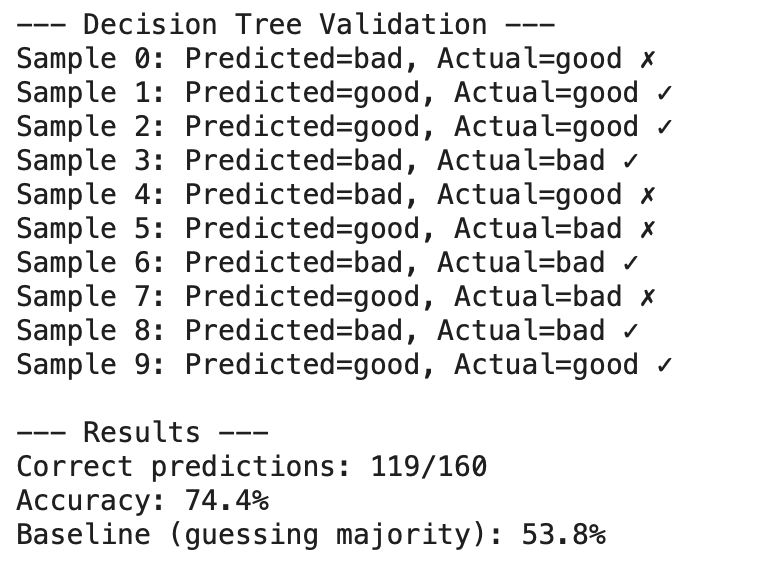

#Conclusion
 the sweet spot is 3 trees which gives the strongest accuracy,

An Even number of trees could be used but the code would have to be altered to account for the chance that the votes by all trees are even.